In [1]:
import os
cwd = os.getcwd()

In [6]:
import numpy as np
from matplotlib import pyplot as plt
import psutil
psutil.virtual_memory()

svmem(total=33731371008, available=30113316864, percent=10.7, used=2903171072, free=17973391360, active=2026967040, inactive=12609703936, buffers=0, cached=12854808576, shared=61849600, slab=409624576)

In [ ]:
from synthdata_utils import grid_torus, scalar_field, noisy_scalar_field, toroidal_to_cart_coord
from synthdata_utils import cart_to_toroidal_coord, onemode_scalar_field, noisy_onemode_scalar_field

In [ ]:
"""
Generating the synthetic data without noise
"""
gridsynth = grid_torus(ngrid_cart = 250, ngrid_tor = 250, R0 = 2)
synthfield_tor = scalar_field(R = gridsynth.R, 
                              theta = gridsynth.theta, 
                              phi = gridsynth.phi)
synthfield_tor_simple = onemode_scalar_field(R = gridsynth.R, 
                                             theta = gridsynth.theta, 
                                             
                                             phi = gridsynth.phi, 
                                             nmodes_phi = 3, nmodes_theta = 3)

#do it on a cartesian example
R1,theta1,phi1 = cart_to_toroidal_coord(x = gridsynth.cart_x, y = gridsynth.cart_y, z = gridsynth.cart_z)
synthfield_cart = scalar_field(R = R1, theta = theta1, phi = phi1)
synthfield_cart_simple = onemode_scalar_field(R = R1, theta = theta1, phi = phi1, 
                                              nmodes_phi = 3, nmodes_theta = 3)

In [ ]:
plt.imshow(synthfield_cart.T[::-1][:,124])

In [ ]:
with open('%s/synthdata3/truefield_cart_'%cwd+'%i.npy'%(250), 'wb') as f:
    np.save(f, synthfield_cart)
f.close()

with open('%s/synthdata3/truefield_cart_simple_'%cwd+'%i.npy'%(250), 'wb') as f:
    np.save(f, synthfield_cart_simple)
f.close()

In [ ]:
"""
Generating the synthetic data with noise, the point is to get something similar to the emc3 simulation,
where you have different noise for each iteration.
"""
noisy_tor = []
noisy_tor_simp = []
noisy_cart = []
noisy_cart_simp = []
for t in range(20):
    noisy_synthfield_tor = noisy_scalar_field(R = gridsynth.R,
                                              theta = gridsynth.theta, 
                                              phi = gridsynth.phi)
    noisy_tor.append(noisy_synthfield_tor)
    noisy_synthfield_tor_simple = noisy_onemode_scalar_field(R = gridsynth.R, 
                                                             theta = gridsynth.theta, 
                                                             phi = gridsynth.phi, 
                                                             nmodes_phi = 3, nmodes_theta = 3)
    noisy_tor_simp.append(noisy_synthfield_tor_simple)
    noisy_synthfield_cart = noisy_scalar_field(R = R1, theta = theta1, phi = phi1)
    noisy_cart.append(noisy_synthfield_cart)
    noisy_synthfield_cart_simple = noisy_onemode_scalar_field(R = R1, theta = theta1, phi = phi1, 
                                                              nmodes_phi = 3, nmodes_theta = 3)
    noisy_cart_simp.append(noisy_synthfield_cart_simple)

In [ ]:
folder = 'Analytical_solution_cart'
"""
with open('%s/synthdata3/'%cwd+folder+'/ts_noisy_tor_'+'%i.npy'%(250), 'wb') as f:
    np.save(f, noisy_tor)
f.close()

with open('%s/synthdata3/'%cwd+folder+'/ts_noisy_tor_simp_'+'%i.npy'%(250), 'wb') as f:
    np.save(f, noisy_tor_simp)
f.close()

with open('%s/synthdata3/'%cwd+folder+'/ts_cart_'+'%i.npy'%(250), 'wb') as f:
    np.save(f, noisy_cart)
f.close()

with open('%s/synthdata3/'%cwd+folder+'/ts_cart_simp_'+'%i.npy'%(250), 'wb') as f:
    np.save(f, noisy_cart_simp)
f.close()"""

In [7]:
folder = 'Analytical_solution_cart'
"""with open('%s/synthdata3/'%cwd+folder+'/ts_noisy_tor_'+'%i.npy'%(250), 'rb') as f:
    noisy_tor = np.load(f)
f.close()

with open('%s/synthdata3/'%cwd+folder+'/ts_noisy_tor_simp_'+'%i.npy'%(250), 'rb') as f:
    noisy_tor_simp = np.load(f)
f.close()"""

#with open('%s/synthdata3/'%cwd+folder+'/ts_cart_'+'%i.npy'%(250), 'rb') as f:
#    noisy_cart = np.load(f)
#f.close()

with open('%s/synthdata3/'%cwd+folder+'/ts_cart_simp_'+'%i.npy'%(250), 'rb') as f:
    noisy_cart_simp = np.load(f)
f.close()

In [ ]:
from makemesh_indices import make_parammesh_vtk_indices, from_indices_to_paramvals
from tvtk.api import tvtk
dimgrid = list([x for x in gridsynth.tor_x.shape[::-1]])
sgrid_synth = tvtk.StructuredGrid(dimensions=dimgrid)
sgrid_synth.points = gridsynth.torflat
sgrid_synth.point_data.scalars = synthfield_tor.ravel()
sgrid_synth.point_data.scalars.name = "pm_noisefree"

In [ ]:
dimgrid

In [ ]:
%gui qt
from mayavi import mlab

In [ ]:
"""
Plotting the actual values in the W7X grid with the electron temperature as a test.
"""
# clear the field
mlab.clf()
#add the dataset to the pipeline, the principle is to add several object on top of each other
src = mlab.pipeline.add_dataset(sgrid_synth)
# make a cut object to cut the 3D volum in slices in a user defined direction
cut = mlab.pipeline.scalar_cut_plane(src)
# add the outline of the 3d domain
mlab.outline()
# add axis to the plot
mlab.axes()

In [ ]:
from ipywidgets import interact, widgets

""""
Comparing the interpolated region with what I should see.
"""
def plot_torfield(field, ip, grid = gridsynth):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot()
    clev = np.arange(field.min(),field.max(),.5)
    c = ax.contourf(grid.cyl_R[:,:,ip], 
                    grid.cyl_z[:,:,ip], 
                    field[:,:,ip], 
                    clev)
    fig.colorbar(c)

def plot_toroidal(ip):
    plot_torfield(field = synthfield_tor_simple, ip = ip)
phislider = widgets.IntSlider(min = 0, max = gridsynth.tor_x.shape[2]-1, value = 0)
interact(plot_toroidal, ip = phislider)

In [ ]:
def plot_fixedR(ir, ip):
    plt.plot(synthfield_tor_simple[ir,:,ip])
Rslider = widgets.IntSlider(min = 0, max = synthfield_tor_simple.shape[0]-1, value = 0)
phislider = widgets.IntSlider(min = 0, max = synthfield_tor_simple.shape[2]-1, value = 0)
interact(plot_fixedR, ir = Rslider, ip = phislider)

In [ ]:
def plot_toroidal(ip):
    plot_torfield(field = synthfield_tor, ip = ip)
phislider = widgets.IntSlider(min = 0, max = gridsynth.tor_x.shape[2]-1, value = 0)
interact(plot_toroidal, ip = phislider)

In [ ]:
def plot_fixedR(ir, ip):
    plt.plot(synthfield_tor[ir,:,ip])
Rslider = widgets.IntSlider(min = 0, max = synthfield_tor.shape[0]-1, value = 0)
phislider = widgets.IntSlider(min = 0, max = synthfield_tor.shape[2]-1, value = 0)
interact(plot_fixedR, ir = Rslider, ip = phislider)

In [ ]:
fig_simple = plt.figure(figsize=(10,10))
axs_simple = fig_simple.subplots(2, 2)
im0 = axs_simple[0,0].imshow(synthfield_cart[:,synthfield_cart.shape[1]//2].T[::-1])
im1 = axs_simple[0,1].imshow(synthfield_cart[:,:,synthfield_cart.shape[2]//2].T[::-1])
im2 = axs_simple[1,0].imshow(synthfield_cart_simple[:,synthfield_cart_simple.shape[1]//2].T[::-1])
im3 = axs_simple[1,1].imshow(synthfield_cart_simple[:,:,synthfield_cart.shape[2]//2].T[::-1])
fig_simple.colorbar(im0, ax = axs_simple[0])
fig_simple.colorbar(im2, ax = axs_simple[1])

In [ ]:
fig_simple = plt.figure(figsize=(10,10))
axs_simple = fig_simple.subplots(2, 2)
im0 = axs_simple[0,0].imshow(noisy_synthfield_cart[:,noisy_synthfield_cart.shape[1]//2].T[::-1])
im1 = axs_simple[0,1].imshow(noisy_synthfield_cart[:,:,noisy_synthfield_cart.shape[2]//2].T[::-1])
im2 = axs_simple[1,0].imshow(noisy_synthfield_cart_simple[:,noisy_synthfield_cart_simple.shape[1]//2].T[::-1])
im3 = axs_simple[1,1].imshow(noisy_synthfield_cart_simple[:,:,noisy_synthfield_cart_simple.shape[2]//2].T[::-1])
fig_simple.colorbar(im0, ax = axs_simple[0])
fig_simple.colorbar(im2, ax = axs_simple[1])

In [ ]:
#idxsynth, weightsynth = make_parammesh_vtk_indices(grid_obj = gridsynth, sgrid = sgrid_synth, tolsqrd=5e-2)

In [ ]:
""""with open('%s/synthdata3/idxs_'%cwd+'%i.npy'%(idxsynth.shape[0]), 'wb') as f:
                np.save(f, idxsynth)
f.close()
with open('%s/synthdata3/weights_'%cwd+'%i.npy'%(idxsynth.shape[0]), 'wb') as f:
                np.save(f, weightsynth)
f.close()"""

In [ ]:
with open('%s/synthdata3/idxs_'%cwd+'%i.npy'%(250), 'rb') as f:
    idxsynth = np.load(f)
f.close()
with open('%s/synthdata3/weights_'%cwd+'%i.npy'%(250), 'rb') as f:
    weightsynth = np.load(f)
f.close()

In [ ]:
pmesh_cart_synth = from_indices_to_paramvals(idxs = idxsynth, 
                                             weights = weightsynth, 
                                             param_torgrid = synthfield_tor)

In [ ]:
pmesh_cart_synth_simple = from_indices_to_paramvals(idxs = idxsynth, 
                                                    weights = weightsynth,
                                                    param_torgrid = synthfield_tor_simple)

In [ ]:
with open('%s/synthdata3/pmesh_cart_synth_noisefree_'%cwd+'%i.npy'%(idxsynth.shape[0]), 'wb') as f:
    np.save(f, pmesh_cart_synth)
f.close()
with open('%s/synthdata3/pmesh_cart_synth_simple_noisefree_'%cwd+'%i.npy'%(idxsynth.shape[0]), 'wb') as f:
    np.save(f, pmesh_cart_synth_simple)
f.close()

In [ ]:
def plot_field_comparison(field1, field2, interpol1, interpol2):
    simp_halfslice_y = field1.shape[1]//2-1
    simp_halfslice_z = field1.shape[2]//2-1
    delta_simple = interpol1 - field1
    delta = interpol2 - field2
    
    fig = plt.figure(figsize=(30,30))
    axs = fig.subplots(2, 2)
    im0 = axs[0,0].imshow(interpol1[:,simp_halfslice_y].T[::-1])
    im1 = axs[0,1].imshow(interpol1[:,:,simp_halfslice_y].T[::-1])
    im2 = axs[1,0].imshow(interpol2[:,simp_halfslice_y].T[::-1])
    im3 = axs[1,1].imshow(interpol2[:,:,simp_halfslice_z].T[::-1])
    fig.colorbar(im0, ax = axs[0,0])
    fig.colorbar(im1, ax = axs[0,1])
    fig.colorbar(im2, ax = axs[1,0])
    fig.colorbar(im3, ax = axs[1,1])
    

    fig_simple = plt.figure(figsize=(30,30))
    axs_simple = fig_simple.subplots(2, 2)
    im0 = axs_simple[0,0].imshow(delta_simple[:,simp_halfslice_y].T[::-1])
    im1 = axs_simple[0,1].imshow(delta_simple[:,:,simp_halfslice_y].T[::-1])
    im2 = axs_simple[1,0].imshow(delta[:,simp_halfslice_y].T[::-1])
    im3 = axs_simple[1,1].imshow(delta[:,:,simp_halfslice_z].T[::-1])
    fig_simple.colorbar(im0, ax = axs_simple[0,0])
    fig_simple.colorbar(im1, ax = axs_simple[0,1])
    fig_simple.colorbar(im2, ax = axs_simple[1,0])
    fig_simple.colorbar(im3, ax = axs_simple[1,1])
    

In [ ]:
plot_field_comparison(field1 = synthfield_cart_simple, field2 = synthfield_cart, 
                      interpol1 = pmesh_cart_synth_simple, interpol2 = pmesh_cart_synth)

In [ ]:
"""with open('%s/synthdata3/ts_noisy_tor_'%cwd+'%i.npy'%(250), 'rb') as f:
    noisy_tor = np.load(f)
f.close()

with open('%s/synthdata3/ts_noisy_tor_simp_'%cwd+'%i.npy'%(250), 'rb') as f:
    noisy_tor_simp = np.load(f)
f.close()

with open('%s/synthdata3/ts_cart_'%cwd+'%i.npy'%(250), 'rb') as f:
    noisy_cart = np.load(f)
f.close()

with open('%s/synthdata3/ts_cart_simp_'%cwd+'%i.npy'%(250), 'rb') as f:
    noisy_cart_simp = np.load(f)
f.close()"""

In [ ]:
pmesh_cart_noisy = []
pmesh_cart_noisy_simp = []
for t in range(20):    
    pmesh_cart_synth_noisy = from_indices_to_paramvals(idxs = idxsynth,
                                                   weights = weightsynth,
                                                   param_torgrid = noisy_tor[t])
    pmesh_cart_noisy.append(pmesh_cart_synth_noisy)
    pmesh_cart_synth_noisy_simp = from_indices_to_paramvals(idxs = idxsynth,
                                                   weights = weightsynth,
                                                   param_torgrid = noisy_tor_simp[t])
    pmesh_cart_noisy_simp.append(pmesh_cart_synth_noisy_simp)

In [ ]:
"Save the noisy interpolated data"

with open('%s/synthdata3/ts_pmesh_cart_noisy'%cwd+'%i.npy'%(idxsynth.shape[0]), 'wb') as f:
                np.save(f, pmesh_cart_noisy)
f.close()

with open('%s/synthdata3/ts_pmesh_cart_noisy_simp'%cwd+'%i.npy'%(idxsynth.shape[0]), 'wb') as f:
                np.save(f, pmesh_cart_noisy_simp)
f.close()

with open('%s/synthdata3/ts_truenoise_'%cwd+'%i.npy'%(idxsynth.shape[0]), 'wb') as f:
                np.save(f, np.array(noisy_tor) - synthfield_tor)
f.close()

with open('%s/synthdata3/ts_truenoise_simple_'%cwd+'%i.npy'%(idxsynth.shape[0]), 'wb') as f:
                np.save(f, np.array(noisy_tor_simp) - synthfield_tor)
f.close()

In [ ]:
folder_interpol = 'Interpolated'
with open('%s/synthdata3/'%cwd+folder_interpol+'/ts_pmesh_cart_noisy'+'%i.npy'%(250), 'rb') as f:
    pmesh_cart_noisy = np.load(f)
f.close()

In [ ]:
noise_interpol = pmesh_cart_noisy[0] - synthfield_cart
plt.hist(noise_interpol.ravel(), bins=100, density=True, label='Noise interpolation')
truenoise = noisy_synthfield_tor - synthfield_tor
plt.hist(truenoise.ravel(), bins=100, density=True, label='Noise true')
plt.title("Noise")
plt.xlabel('Noise value')
plt.ylabel('# samples')
plt.legend()

In [ ]:
psutil.virtual_memory()

In [19]:
from skimage.restoration import denoise_wavelet, cycle_spin
from skimage.metrics import peak_signal_noise_ratio
import time
psutil.virtual_memory()

svmem(total=33731371008, available=22408765440, percent=33.6, used=10598768640, free=5121462272, active=12217929728, inactive=15241809920, buffers=0, cached=18011140096, shared=64999424, slab=421507072)

In [20]:
def shiftinv_wavelet_denoising(tsdata, max_shifts = (4,4,4)):
    """
    Args:
     - tsdata, list of ndarray np.float64 (nt,)(nr,)(ix, iy, iz), list of times of list of regions of parameter mesh
     - int_phi, list of int, defining the interval in phi direction
    Out:
    """
    int_y = [0,tsdata[0].shape[1]]
    tik = time.time()
    denoised_t = []
    for t in range(len(tsdata)):
        img = tsdata[t].T[::-1,int_y[0]:int_y[1]].copy()
        imgisnan = np.isnan(img)
        img[imgisnan] = np.zeros(img[imgisnan].shape)
        # multichannel = bool, do you have rgb/csv/hsv etc?, convert2ycbcr = bool, req multichannel = True
        denoise_kwargs = dict(rescale_sigma=False)
        denoised = cycle_spin(img, func=denoise_wavelet, 
                              max_shifts=max_shifts, func_kw = denoise_kwargs)
        del img
        # set values that were nan before the denoising back to nan
        denoised[imgisnan] = np.ones(denoised[imgisnan].shape)*np.nan
        del imgisnan
        denoised_t.append(denoised)
        del denoised
    tok = time.time()
    return denoised_t, tok-tik

In [ ]:
# extracting the noise from the simple example using the filter
root_interpol = '%s/synthdata3/'%cwd+'Interpolated'
with open(root_interpol+'/ts_pmesh_cart_noisy_simp%i.npy'%(250), 'rb') as f:
    pmesh_cart_noisy_simple = np.load(f)
f.close()
only_filter_250_simple, runtime_only_filter_250_simple = shiftinv_wavelet_denoising(tsdata = pmesh_cart_noisy_simple)

In [ ]:
pmesh_cart_noisy_filtered, runtime = shiftinv_wavelet_denoising(tsdata = pmesh_cart_noisy)

# PSNR analysis of convergence with regards to choice of max cycle shifts

In [ ]:
ms_shifts = [(2*i,2*i,2*i) for i in range(1,5)]
print(ms_shifts)
type(synthfield_cart)

In [ ]:
def psnr_scan(original, noisy_ts, ms):
    psnr_l = []
    runtimes = []
    for i in range(len(ms)):
        filtered, runtime = shiftinv_wavelet_denoising(tsdata = noisy_ts, 
                                                       max_shifts = ms[i])
        psnr_ts = np.zeros(len(filtered))
        for t in range(len(filtered)):
            psnr_ts[t] = peak_signal_noise_ratio(image_true = original, 
                                                 image_test = np.array(filtered[t]),
                                                 data_range = np.max(filtered[t])-np.min(filtered[t]))
        psnr_l.append(psnr_ts)
        runtimes.append(runtime)
    return psnr_l, runtimes

In [ ]:
psnr_scan_250_10modes, runtime_scan_250_10modes = psnr_scan(original = synthfield_cart, 
                                                            noisy_ts = noisy_cart, 
                                                            ms = ms_shifts)

In [ ]:
psnr_scan_250_10modes_interpolated, runtime_scan_250_10modes_interpol = psnr_scan(original = synthfield_cart,
                                                                                  noisy_ts = pmesh_cart_noisy,
                                                                                  ms = ms_shifts[0])

In [ ]:
psnr_scan_250_10modes_interpolated

In [ ]:
plt.title("Runtime $n_{\\phi} = n_{\\theta} = 10$")
plt.plot(np.arange(1,5),runtime_scan_250_10modes)
plt.ylabel("Runtime")
plt.xlabel("Max cycle shifts along each axis")

In [ ]:
plt.title("PSNR convergence")
for t in range(np.array(psnr_scan_250_10modes).shape[1]):
    plt.plot(np.arange(1,5)*2,np.array(psnr_scan_250_10modes)[:,t], '-o')
plt.xlabel("Max cycle shifts along each axis")
plt.ylabel("PSNR $\mathrm{dB}$")
plt.grid()

In [ ]:
psnr_scan_250_10modes_interpolated

In [ ]:
runtime_scan_250_10modes_interpol

In [ ]:
plt.title("PSNR convergence interpolated data")
for t in range(np.array(psnr_scan_250_10modes_interpolated).shape[1]):
    plt.plot(np.arange(1,5)*2,np.array(psnr_scan_250_10modes_interpolated)[:,t], '-o')
plt.xlabel("Max cycle shifts along each axis")
plt.ylabel("PSNR $\mathrm{dB}$")
plt.xlim(0,10)
plt.ylim(0,100)
plt.grid()

In [ ]:
print(runtime)
with open('%s/synthdata3/pmesh_cart_noisy_filtered_'%cwd+'%i.npy'%(250), 'wb') as f:
    np.save(f, pmesh_cart_noisy_filtered)
f.close()

In [ ]:
with open('%s/synthdata3/ts_cart_'%cwd+'%i.npy'%(250), 'rb') as f:
    noisy_cart = np.load(f)
f.close()
only_filter, runtime = shiftinv_wavelet_denoising(tsdata = noisy_cart)

In [ ]:
with open('%s/synthdata3/only_filter_'%cwd+'%i.npy'%(250), 'wb') as f:
    np.save(f, only_filter)
f.close()

In [ ]:
with open('%s/synthdata3/only_filter_'%cwd+'%i.npy'%(250), 'rb') as f:
    only_filter = np.load(f)
f.close()

In [ ]:
plt.figure(figsize=(20,20))
im = plt.imshow(only_filter[0][:,124])
plt.colorbar(im)

In [ ]:
halfslice_y = noisy_cart_filtered[0].shape[1]//2
halfslice_z = noisy_cart_filtered[0].shape[2]//2

fig_simple = plt.figure(figsize=(30,30))
axs_simple = fig_simple.subplots(2, 2)
im0 = axs_simple[0,0].imshow(noisy_cart_filtered[0][:,halfslice_y])
im1 = axs_simple[0,1].imshow(noisy_cart_filtered[0][halfslice_z])
im2 = axs_simple[1,0].imshow(noisy_cart_filtered[1][:,halfslice_y])
im3 = axs_simple[1,1].imshow(noisy_cart_filtered[1][halfslice_z])
fig_simple.colorbar(im0, ax = axs_simple[0])
fig_simple.colorbar(im2, ax = axs_simple[1])

# Noise calculation of example with $n_{\phi} = n_{\theta} = 10$

In [ ]:
root_n10 = '%s/synthdata3/'%cwd

In [ ]:
with open(root_n10+'Interpolated_filtered/pmesh_cart_noisy_filtered_250'+'.npy', 'rb') as f:
    pmesh_denoised_250 = np.load(f)
f.close()

plt.figure(figsize=(20,20))
im = plt.imshow(pmesh_denoised_250[0][:,125])
plt.colorbar(im)

In [ ]:
with open(root_n10+'Analytical_solution_cart/truefield_cart_%i.npy'%(250), 'rb') as f:
    field_true_cart = np.load(f)
f.close()

"""
with open(root_n10+'/ts_noisy_tor_%i.npy'%(250), 'rb') as f:
    noisy_tor = np.load(f)
f.close()

with open(root_n10+'%s/synthdata3/ts_noisy_tor_simp_%i.npy'%(250), 'rb') as f:
    noisy_tor_simp = np.load(f)
f.close()
"""
"""with open(root_n10+'Analytical_solution_cart/ts_cart_%i.npy'%(250), 'rb') as f:
    noisy_cart = np.load(f)
f.close()"""

"""with open(root_n10+'%s/synthdata3/ts_cart_simp_%i.npy'%(250), 'rb') as f:
    pmesh_cart_noisy_simp = np.load(f)
f.close()

with open(root_n10+'%s/synthdata3/ts_pmesh_cart_noisy%i.npy'%(250), 'rb') as f:
    pmesh_cart_noisy = np.load(f)
f.close()"""

In [ ]:
truenoise = np.array([noisy_cart[i].T[::-1] - synthfield_cart.T[::-1] for i in range(len(noisy_cart))])

In [ ]:
only_filter = shiftinv_wavelet_denoising(tsdata = noisy_cart)

In [ ]:
with open(root_n10+'Filtered/only_filter_%i_retry.npy'%(250), 'wb') as f:
    np.save(f, only_filter[0])
f.close()

In [ ]:
with open(root_n10+'Filtered/only_filter_%i_retry.npy'%(250), 'rb') as f:
    only_filter = np.load(f)
f.close()

In [ ]:
noise_filter = np.array([only_filter[i] - field_true_cart.T[::-1] for i in range(len(only_filter))])

In [ ]:
noise_filter.shape

In [ ]:
plt.imshow(noise_filter[0,:,124])
plt.colorbar()

In [ ]:
noise_tor_mean = np.array(noisy_cart) - sum(noisy_cart)/len(noisy_cart)
noise_tor_filter = np.array([only_filter[i] - synthfield_cart.T[::-1] for i in range(len(only_filter))])
noise_tor_interpol_filter = np.array([pmesh_cart_noisy_filtered[i] - synthfield_cart.T[::-1] for i in range(len(pmesh_cart_noisy_filtered))])

In [ ]:
plt.imshow(pmesh_cart_noisy_filtered[0][:,124])

In [ ]:
plt.imshow(synthfield_cart.T[::-1][:,124])

In [ ]:
for i in range(20):
    with open('%s/synthdata3/ts_'%cwd+'%i_denoised_filter_%i.npy'%(noise_tor_filter[0].shape[0], i), 'wb') as f_ts:
                np.save(f_ts, noise_tor_filter[i])
f_ts.close()

for i in range(20):
    with open('%s/synthdata3/ts_'%cwd+'%i_denoised_interpol_filter_%i.npy'%(noise_tor_filter[0].shape[0], i), 'wb') as f_ts:
                np.save(f_ts, noise_tor_interpol_filter[i])
f_ts.close()

for i in range(20):
    with open('%s/synthdata3/ts_'%cwd+'%i_denoised_mean_%i.npy'%(noise_tor_filter[0].shape[0], i), 'wb') as f_ts:
                np.save(f_ts, noise_tor_mean[i])
f_ts.close()

In [ ]:
"""noise_tor_filter = []
for i in range(20):
    with open('%s/synthdata3/ts_'%cwd+'%i_denoised_filter_%i.npy'%(250, i), 'rb') as f_ts:
        temp_data = np.load(f_ts)
        noise_tor_filter.append(temp_data)
        del temp_data             
f_ts.close()
noise_tor_filter = np.array(noise_tor_filter)

noise_tor_mean = []
for i in range(20):
    with open('%s/synthdata3/ts_'%cwd+'%i_denoised_mean_%i.npy'%(250, i), 'rb') as f_ts:
        temp_data = np.load(f_ts)
        noise_tor_mean.append(temp_data)
        del temp_data             
f_ts.close()
noise_tor_mean = np.array(noise_tor_mean)"""

In [ ]:
noise_tor_mean.ravel().shape

In [ ]:
"""import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 500000000
"""
plt.plot(noise_tor_mean.ravel()[:int(1e4)], noise_tor_filter.ravel()[:int(1e4)], 'k.')
plt.xlabel('$\\theta_t - \\langle \\theta \\rangle$')
plt.ylabel('$\\theta_t - \\tilde{\\theta}_t$')

In [ ]:
plt.plot(noise_tor_mean.ravel()[:int(1e4)], noise_tor_mean.ravel()[:int(1e4)], 'k.')
plt.ylabel('$\\theta_t - \\langle \\theta \\rangle$')
plt.xlabel('$\\epsilon$')

In [ ]:
plt.plot(truenoise.ravel()[:int(1e4)], noise_tor_filter.ravel()[:int(1e4)], 'k.')
plt.xlabel('$\\epsilon$')
plt.ylabel('$\\theta_t - \\tilde{\\theta}_t$')

In [ ]:
plt.plot(truenoise.ravel()[int(9e7):int(1e8)], noise_tor_interpol_filter.ravel()[int(9e7):int(1e8)], 'k.')
plt.xlabel('$\\epsilon$')
plt.ylabel('$\\theta_t - \\tilde{\\theta}_t^{(interpol)}$')

In [ ]:
std_filter = np.nanstd(noise_tor_filter, axis = )
std_mean = np.std(noise_tor_mean.ravel())
std_true = np.nanstd(truenoise.ravel())

# Noise calculation for example with $n_{\phi} = n_{\theta} = 3$

In [8]:
psutil.virtual_memory()
#open necessary datasets
root = '%s/synthdata3/'%cwd

In [9]:
# load true simple field
with open(root+'Analytical_solution_cart/truefield_cart_simple_%i.npy'%(250), 'rb') as f:
    truefield_simple = np.load(f)

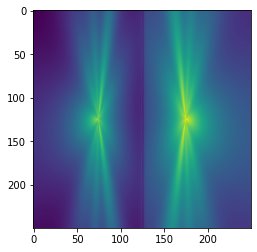

In [12]:
plt.imshow(truefield_simple[:,124].T[::-1])

In [ ]:
# load the interpolated noisy field
with open(root+'Interpolated/ts_pmesh_cart_noisy_simp%i.npy'%(250), 'rb') as f:
    pmesh_cart_synth_simple = np.load(f)
error_interpol_simple = [pmesh_cart_synth_simple[i] - truefield_simple for i in range(pmesh_cart_synth_simple.shape[0])]
error_interpol_simple = np.array(error_interpol_simple)

In [40]:
# load the interpolated noisy field
with open(root+'Interpolated/ts_pmesh_cart_noisy_simp%i.npy'%(250), 'rb') as f:
    pmesh_cart_synth_simple = np.load(f)

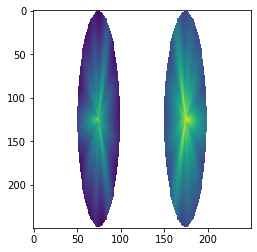

In [45]:
plt.imshow(pmesh_cart_synth_simple[0,:,124].T[::-1])

In [ ]:
error_interpol_simple = [pmesh_cart_synth_simple[i] - truefield_simple for i in range(pmesh_cart_synth_simple.shape[0])]
error_interpol_simple = np.array(error_interpol_simple)

In [ ]:
with open(root+'Interpolated/error_interpol_simple_%i.npy'%(250), 'wb') as f:
    np.save(f, error_interpol_simple)

In [ ]:
plt.figure(figsize=(20,20))
plt.title("Interpolation error for $n_{\\phi} = n_{\\theta} = 3$")
plt.imshow(error_interpol_simple[0,:,124].T[::1])
plt.colorbar()

In [ ]:
#field_cart_filter_simple = shiftinv_wavelet_denoising(tsdata = noisy_cart_simple)

In [60]:
field_cart_interpol_filter_simple, runtime = shiftinv_wavelet_denoising(tsdata = pmesh_cart_synth_simple)

In [62]:
field_cart_interpol_filter_simple = np.array(field_cart_interpol_filter_simple)
field_cart_interpol_filter_simple.shape

(20, 250, 250, 250)

In [63]:
with open(root+'Interpolated_filtered/pmesh_cart_noisy_filtered_%i_simple.npy'%(250), 'wb') as f:
    np.save(f, field_cart_interpol_filter_simple)
f.close()

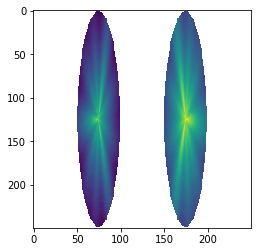

In [64]:
plt.imshow(field_cart_interpol_filter_simple[0,:,124])

In [68]:
noise_cart_interpol_filter_simple = [field_cart_interpol_filter_simple[i] - truefield_simple.T[::-1] for i in range(field_cart_interpol_filter_simple.shape[0])]
noise_cart_interpol_filter_simple = np.array(noise_cart_interpol_filter_simple)

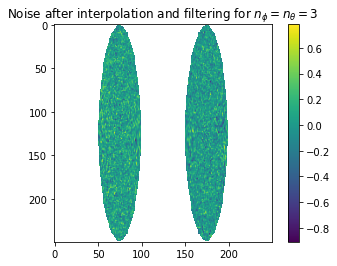

In [71]:
plt.title('Noise after interpolation and filtering for $n_{\\phi} = n_{\\theta} = 3$')
plt.imshow(noise_cart_interpol_filter_simple[0,:,124])
plt.colorbar()

In [72]:
with open(root+'Interpolated_filtered/ts_noise_pmesh_cart_filtered_%i_simple.npy'%250,'wb') as f:
    np.save(f, noise_cart_interpol_filter_simple)
f.close()

In [36]:
with open(root+'Interpolated_filtered/ts_noise_pmesh_cart_filtered_%i_simple.npy'%250,'rb') as f:
    noise_cart_interpol_filter_simple = np.load(f)
f.close()

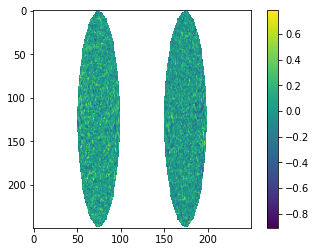

In [74]:
plt.imshow(noise_cart_interpol_filter_simple[0,:,124])
plt.colorbar()

In [33]:
noise_filter_simple = [field_cart_filter_simple[i] - truefield_simple.T[::-1] for i in range(len(field_cart_filter_simple))]
noise_filter_simple = np.array(noise_filter_simple)

In [34]:
with open(root+'Filtered/noise_filter_%i_simple.npy'%(250), 'wb') as f:
    np.save(f, noise_filter_simple)
f.close()

In [25]:
with open(root+'Filtered/only_filter_%i_simple.npy'%(250), 'rb') as f:
    only_filter_simple = np.load(f)
f.close()

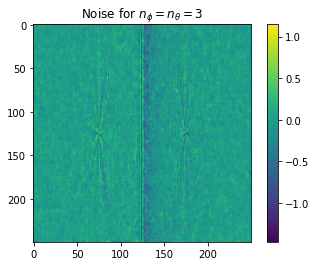

In [39]:
plt.title("Noise for $n_{\\phi}=n_{\\theta} = 3$")
plt.imshow(noise_filter_simple[0,:,124])
plt.colorbar()

In [ ]:
pmesh_cart_synth_simple.shape
pmesh_cart_synth_simple
plt.figure(figsize=(20,20))
plt.title("Field for $n_{\\phi} = n_{\\theta} = 3$")
plt.imshow(np.array(pmesh_cart_filter_simple)[0,:,125])
plt.colorbar()

In [ ]:
plt.figure(figsize=(20,20))
plt.title("Noise for $n_{\\phi} = n_{\\theta} = 3$")
plt.imshow(noise_filter_simple[0,:,125].T[::-1])
plt.colorbar()

In [ ]:
with open(root+'Filtered/only_filter_%i_simple.npy'%(250), 'rb') as f:
    noise_filter_simple = np.load(f)
f.close()
with open(root+'Analytical_solution_cart/ts_cart_simp_%i.npy'%(250), 'rb') as f:
    field_noisy_simple = np.load(f)
f.close()
noise_mean_simple = field_noisy_simple - np.nanmean(field_noisy_simple, axis=0)
noise_true_simple = [field_noisy_simple[i] - truefield_simple for i in range(field_noisy_simple.shape[0])]
noise_true_simple = np.array(noise_true_simple)

In [ ]:
with open(root+'Analytical_solution_cart/noise_true_cart_simple_%i.npy'%(250), 'wb') as f:
    np.save(f, noise_true_simple)
f.close()

In [ ]:
plt.plot(noise_mean_simple.ravel()[:int(1e6)], noise_filter_simple.ravel()[:int(1e6)], 'k.')
plt.xlabel('$\\theta_t - \\langle \\theta \\rangle$')
plt.ylabel('$\\theta_t - \\tilde{\\theta}_t$')

In [ ]:
plt.plot(noise_true_simple[0].ravel()[:int(1e7)], noise_mean_simple.ravel()[:int(1e7)], 'k.')
plt.ylabel('$\\theta_t - \\langle \\theta \\rangle$')
plt.xlabel('$\\epsilon$')

In [ ]:
plt.plot(noise_true_simple[0].ravel()[:int(1e7)], noise_filter_simple.ravel()[:int(1e7)], 'k.')
plt.xlabel('$\\epsilon$')
plt.ylabel('$\\theta_t - \\tilde{\\theta}_t$')

In [ ]:
plt.plot(noise_true_simple[0].ravel()[:int(1e7)], noise_tor_interpol_filter_simple.ravel()[:int(1e7)], 'k.')
plt.xlabel('$\\epsilon$')
plt.ylabel('$\\theta_t - \\tilde{\\theta}_t^{(interpol)}$')

# $L_2$-norm as a measure for noise and error

In [ ]:
def make_ts_import(nsim, folder_file):
    ts = []
    for i in range(1,nsim):
        with open('%s/synthdata3/'%cwd+folder_file%(250,i)+'.npy', 'rb') as f:
            noise_i = np.load(f)
        f.close()
        ts.append(noise_i)
    return ts
ts_noise_filter = make_ts_import(nsim = 20, folder_file = 'Noise_filter/ts_%i_denoised_filter_%i')

ts_noise_mean = make_ts_import(nsim = 20, folder_file = 'Noise_mean/ts_%i_denoised_mean_%i')

with open('%s/synthdata3/'%cwd+'Interpolated/ts_pmesh_cart_noisy%i'%(250)+'.npy', 'rb') as f:
    ts_noise_interpolation = np.load(f)
f.close()

with open('%s/synthdata3/'%cwd+'Interpolated_filtered/ts_noise_pmesh_cart_filtered_%i'%(250)+'.npy', 'rb') as f:
    ts_noise_interpolation_filter = np.load(f)
f.close()

In [ ]:
def l2norm_scalarnoise(noise):
    epsilon = np.nansum((noise**2).ravel())
    return epsilon

In [ ]:
def make_l2_list(ts_noise):
    l2_list_noise = []
    for i in range(len(ts_noise)):
        l2_noise_i = l2norm_scalarnoise(noise = ts_noise[i])
        l2_list_noise.append(l2_noise_i)
    return l2_list_noise

# $L_2$-norm of field with $n_{\phi} = n_{\theta} = 10$

In [ ]:
l2_list_noise_mean = make_l2_list(ts_noise = ts_noise_mean)
l2_list_noise_filter = make_l2_list(ts_noise = ts_noise_filter)
l2_list_noise_interpolation = make_l2_list(ts_noise = [ts_noise_interpolation[i] - synthfield_cart for i in range(len(ts_noise_interpolation))])
l2_list_noise_interpolation_filter = make_l2_list(ts_noise = [ts_noise_interpolation_filter[i] - synthfield_cart for i in range(len(ts_noise_interpolation_filter))])

In [ ]:
print(l2_list_noise_mean)
with open('%s/synthdata3/'%cwd+'L2_noise/l2_%i_mean.npy'%(250), 'wb') as f:
    np.save(f, l2_list_noise_interpolation_filter)

In [ ]:
with open('%s/synthdata3/'%cwd+'L2_noise/l2_%i_filter.npy'%(250), 'rb') as f:
    l2_filter = np.load(f)
with open('%s/synthdata3/'%cwd+'L2_noise/l2_%i_interpolated.npy'%(250), 'rb') as f:
    l2_interpol = np.load(f)
    
with open('%s/synthdata3/'%cwd+'L2_noise/l2_%i_interpolated_filtered.npy'%(250), 'rb') as f:
    l2_interpolated_filtered = np.load(f)

np.set_printoptions(precision=1)
print([ '%.1f' % elem for elem in l2_filter ])
print([ '%.1f' % elem for elem in l2_interpol ])
print([ '%.1f' % elem for elem in l2_interpolated_filtered ])
print([ '%.1f' % elem for elem in l2_list_noise_mean ])

In [ ]:
t1 = np.arange(1,20)
t2 = np.arange(0,20)
plt.scatter(t1, l2_filter, label='$L_2$-filter')
plt.scatter(t2, l2_interpol, label='$L_2$-interpol')
plt.scatter(t2, l2_interpolated_filtered, label='$L_2$-interpol_filtered')
plt.scatter(t1, l2_list_noise_mean, label='$L_2$-mean')
plt.legend()


In [ ]:
plt.scatter(t1, l2_filter, label='$L_2$-filter')
plt.scatter(t2, l2_interpol, label='$L_2$-interpol')
plt.scatter(t1, l2_list_noise_mean, label='$L_2$-mean')
plt.legend()

In [ ]:
plt.scatter(t2, l2_interpolated_filtered, label='$L_2$-interpol_filtered')

plt.legend()


# $L_2$-norm of field with $n_{\phi} = n_{\theta} = 3$

In [ ]:
l2_list_noise_mean = make_l2_list(ts_noise = noise_mean_simple)
l2_list_noise_filter = make_l2_list(ts_noise = ts_noise_filter)
l2_list_noise_interpolation = make_l2_list(ts_noise = [ts_noise_interpolation[i] - synthfield_cart for i in range(len(ts_noise_interpolation))])
l2_list_noise_interpolation_filter = make_l2_list(ts_noise = [ts_noise_interpolation_filter[i] - synthfield_cart for i in range(len(ts_noise_interpolation_filter))])